# Make figure 4 of Wenegrat et al. 2022 'A Century of Observed Temperature Change in the Indian Ocean'

In [ ]:
%%capture
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install geoplot
!pip install gsw
!pip install xarray
!pip install netcdf4
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
!pip install cmocean
!pip install regionmask


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import pandas as pd
from scipy.optimize import lsq_linear
from typing import Iterable
from scipy import stats
import pyproj as proj
import scipy.interpolate as interpolate
import cmocean as cmo
import warnings
import regionmask

import sys
sys.path.insert(0,'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/src')
from importlib import reload
import loadPickle as loadPickle

warnings.filterwarnings("ignore", category=DeprecationWarning) 

## LOAD THE DATA

In [ ]:
# LOAD THE CRUISE DATA
reload(loadPickle)
cutlat = -50
cruises_dset = loadPickle.loadPickle('/content/drive/My Drive/WOD Historic Data/ALL_CRUISES_v0p8.pkl', cutlat)
cruises_dset

<xarray.Dataset>
Dimensions:                    (index: 534)
Coordinates:
  * index                      (index) int64 10 11 12 13 14 ... 615 616 617 618
Data variables: (12/40)
    Station                    (index) object '40' '40' '40' ... '181' '181'
    Date                       (index) datetime64[ns] 1874-10-08 ... 1906-08-14
    Lat degrees                (index) float64 -39.0 -39.0 -39.0 ... -9.0 -9.0
    Lat minutes                (index) float64 -9.5 -9.5 -9.5 ... -18.0 -18.0
    Lon degrees                (index) float64 20.0 20.0 20.0 ... 112.0 112.0
    Lon minutes                (index) float64 56.0 56.0 56.0 ... 9.0 9.0 9.0
    ...                         ...
    delta_T_seasonal_5564      (index) float64 -1.05 -1.454 ... -0.7273 -0.2845
    WOA_temp_seasonal_5564     (index) float64 18.15 16.85 15.55 ... 8.873 1.416
    delta_T_merged             (index) float64 -0.6061 -0.3704 ... -0.3018
    WOA_temp                   (index) float64 18.59 17.93 16.96 ... 8.995 1.398
    delta_T_merged_5564        (index) float64 -1.832 -1.609 ... -0.8942 -0.2845
    WOA_temp_5564              (index) float64 17.37 16.69 15.22 ... 8.706 1.416

In [ ]:
# LOAD ERA REANALYSIS
ersst = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc')

rmask = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50.mask(ersst, lat_name='lat', lon_name='lon')
regions = [5, 13, 52, 10, 36] #Together these define the IO
ersst = ersst.where(rmask.isin(regions), drop=True)
ersst

<xarray.Dataset>
Dimensions:    (lat: 43, lon: 74, nbnds: 2, time: 2019)
Coordinates:
  * lat        (lat) float32 24.0 22.0 20.0 18.0 ... -54.0 -56.0 -58.0 -60.0
  * lon        (lon) float32 20.0 22.0 24.0 26.0 ... 160.0 162.0 164.0 166.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2022-03-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds, lat, lon) float64 nan nan ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 nan nan nan nan ... 3.177 3.633 4.114
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-04-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [ ]:
# LOAD ORA20C ENSEMBLE MEAN
opamean = xr.open_dataset('/content/drive/My Drive/WOD HISTORIC DATA/Jacob Analysis/ora20c/ftp-icdc.cen.uni-hamburg.de/ora20c/opamean_all_10.nc', chunks={'time':12})
opamean

,Array,Chunk
Bytes,1.44 GB,13.06 MB
Shape,"(1320, 34, 80, 100)","(12, 34, 80, 100)"
Count,111 Tasks,110 Chunks
Type,float32,numpy.ndarray


In [ ]:
# LOAD THE WOA18 DATA
lonl = 60 # Here temp is averaged over this lon range (rather than full basin)
lonr = 80

# FIRST LOAD MODERN A5B7 TIME PERIOD
url=f'/content/drive/My Drive/WOD Historic Data/WOA/woa18_A5B7_t00_01.nc' #ANNUAL AVG
WOA = xr.open_dataset(url, decode_times=False)
#rmask = regionmask.defined_regions.natural_earth.ocean_basins_50.mask(WOA_JFM, lat_name='lat', lon_name='lon')
#WOA_TEMPS = WOA_JFM.where(rmask.isin(regions), drop=True).mean('lon').t_an.squeeze()
WOA_TEMPS = WOA.sel(lon=slice(lonl, lonr)).mean('lon').t_an.squeeze()
WOA_TEMPS = WOA_TEMPS.sel(lat=slice(-60, 15))

# NEXT LOAD MID-CENTURY TIME PERIOD (5564)
#url=f'https://data.nodc.noaa.gov/thredds/dodsC/ncei/woa/temperature/5564/1.00/woa18_5564_t16_01.nc' # Climatology is 1955-1964, 1 degree
url=f'/content/drive/My Drive/WOD Historic Data/WOA/woa18_5564_t00_01.nc'
#url=f'/content/drive/My Drive/WOD Historic Data/WOA/woa18_6574_t00_01.nc'

WOA_OLD = xr.open_dataset(url, decode_times=False)
WOA_OLD = WOA_OLD.sel(lon=slice(lonl, lonr)).mean('lon').t_an.squeeze()
WOA_OLD = WOA_OLD.sel(lat=slice(-60, 15))

## DO THE CALCULATIONS


In [ ]:
### WOA CALCULATIONS ###

# DIFF BETWEEN MODERN AND MID-CENTURY
WOA_DIFF = WOA_TEMPS - WOA_OLD

# 1 DEGREE SHIFT DIFF
WOA_SHIFT = WOA_TEMPS.interp(lat = WOA_TEMPS.lat-1., method='linear').values
WOA_SDIFF = WOA_TEMPS.values - WOA_SHIFT

In [ ]:
### CALCULATE SURFACE ISOTHERM DISPLACEMENTS ###

smooth = 12*3
ersst_y = ersst.rolling(time=smooth, min_periods=smooth, center=True).mean()
emean = ersst_y.mean('lon')
targets = np.linspace(6, 26, 11)
nl = emean.time.size
em = np.nan*np.zeros((nl,len(targets)))
from IPython.display import clear_output

for i in range(0, nl, 1):
  clear_output(wait=True)
  print(f'Done: {i}/{nl}')
  sst = emean.isel(time=i).sst
  try:
    ind = np.nanargmax(sst.values)
    sst[0:ind] = np.nan
    mask = np.isfinite(sst)
    if (sum(mask)>1):
      em[i,:]= np.interp(targets, np.flip(sst[mask].values), np.flip(emean.isel(time=i).lat[mask].values))
  except:
    print(i)
    #arginds = np.argsort(emean.isel(time=i).sst[mask])
    #em[i,:]= np.interp(targets, emean.isel(time=i).sst[mask].values[arginds], emean.isel(time=i).lat[mask].values[arginds])

Done: 2018/2019
2018


## MAKE THE FIGURE!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


Avg. shift modern: -1.1613241281373305
Avg. shift mid: -0.01217332329612842
Max WOA_DIFF: 1.5299949645996094, Min WOA_DIFF: -0.8300590515136719
Max WOA_SDIFF: 2.378248691558838, Min WOA_SDIFF: -1.0354690551757812


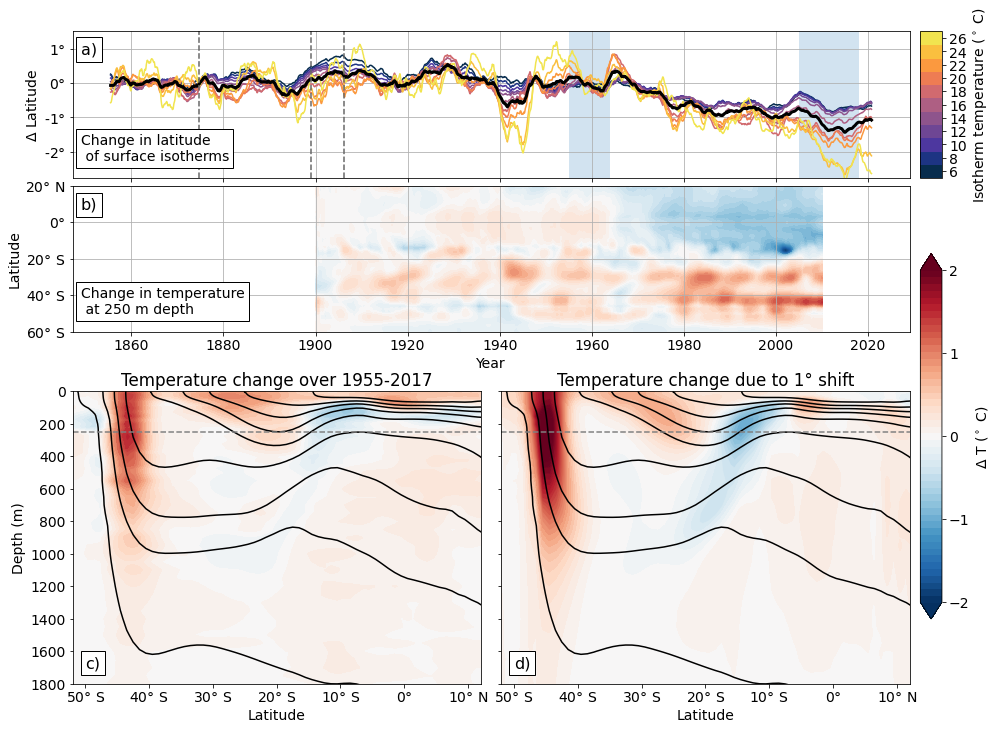

In [ ]:
# Add the Reanalysis

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams.update({'font.size':14})


# Gazelle
indGL = np.argmin(np.abs(emean.time.values - np.nanmin(cruises_dset.where((cruises_dset.cruise=='Gazelle')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
indGR =  np.argmin(np.abs(emean.time.values - np.nanmax(cruises_dset.where((cruises_dset.cruise=='Gazelle')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
# Valdivia
indVL = np.argmin(np.abs(emean.time.values - np.nanmin(cruises_dset.where((cruises_dset.cruise=='Valdivia')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
indVR =  np.argmin(np.abs(emean.time.values - np.nanmax(cruises_dset.where((cruises_dset.cruise=='Valdivia')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
# Planet
indPL = np.argmin(np.abs(emean.time.values - np.nanmin(cruises_dset.where((cruises_dset.cruise=='Planet')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
indPR =  np.argmin(np.abs(emean.time.values - np.nanmax(cruises_dset.where((cruises_dset.cruise=='Planet')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)))
#em0 = (1/3)*(np.nanmean(em[indGL:indGR,:], axis=0) + np.nanmean(em[indVL:indVR,:], axis=0) + np.nanmean(em[indPL:indPR,:], axis=0))
#em0 = (1/2)*(np.nanmean(em[indGL:indGR,:], axis=0) + np.nanmean(em[indVL:indVR,:], axis=0) )



indl = np.argmin(np.abs(emean.time.values - np.datetime64('1860')))
indr = np.argmin(np.abs(emean.time.values - np.datetime64('1870')))
em0 = np.nanmean(em[indl:indr,:],axis=0)

indl = np.argmin(np.abs(emean.time.values - np.datetime64('1955')))
indr = np.argmin(np.abs(emean.time.values - np.datetime64('1964')))
#em0 = np.nanmean(em[indl:indr,:],axis=0)

indg = np.argmin(np.abs(emean.time.values - np.datetime64('1872')))
indv = np.argmin(np.abs(emean.time.values - np.datetime64('1898')))
indp = np.argmin(np.abs(emean.time.values - np.datetime64('1907')))
#em0 = np.nanmean(em[[indg, indv, indp]], axis=0)
#em0 = np.nanmean(em[0:indp], axis=0)
nt, n_lines = em.shape
x = emean.time.values
y = em - em0
c = targets

#norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
#cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.viridis)
#cmap.set_array([])

####################### DEFINE FIGURE ########################

fig =  plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(4,2, height_ratios=[0.5, 0.5, 0.15, 1])

#######################   ST PLOT.   ########################
ax = fig.add_subplot(gs[0, :])
cmap = mpl.colors.LinearSegmentedColormap('new',cmo.tools.get_dict(cmo.tools.crop_by_percent(cmo.cm.thermal_r, 10), len(targets)))
plt.register_cmap(cmap=cmap)
cmap = mpl.cm.get_cmap('new', len(targets))
cmap = cmap.reversed('new')
dummie_cax = ax.scatter(c, c, c=np.linspace(targets[0]-1, targets[-1]+1, 11), cmap=cmap)
# Clear axis
ax.cla()

for i, yi in enumerate(y.T):
    mask = np.isfinite(yi)
    ax.plot(x[mask], yi[mask], c=cmap(i))

ax.plot(x[mask], np.nanmean(y, axis=1)[mask], color='k', linewidth=3)
endTime = np.datetime64('2018')
startTime = np.datetime64('2005')
diffTime = endTime - startTime
rect = patches.Rectangle((startTime, -3), diffTime, 10, alpha=0.2)
plt.gca().add_patch(rect)

endTime = np.datetime64('1964')
startTime = np.datetime64('1955')
diffTime = endTime - startTime
rect = patches.Rectangle((startTime, -3), diffTime, 10, alpha=0.2)
plt.gca().add_patch(rect)

plt.ylim(-2.75, 1.5)
# Gazelle
startTime = np.nanmin(cruises_dset.where((cruises_dset.cruise=='Gazelle')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)
plt.axvline(startTime, linestyle='--', color='0.4')
# Valdivia
startTime = np.nanmin(cruises_dset.where((cruises_dset.cruise=='Valdivia')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)
plt.axvline(startTime, linestyle='--', color='0.4')
# Planet
startTime = np.nanmin(cruises_dset.where((cruises_dset.cruise=='Planet')&(cruises_dset.Date!=np.datetime64('NaT'))).Date.values)
plt.axvline(startTime, linestyle='--', color='0.4')

plt.grid()
plt.ylabel('$\Delta$ Latitude')




####################### WOD DIFF ########################
conts = np.linspace(-2, 2, 50)

# Start with modern minus 1950 climatology
#ax[0].pcolor(WOA_DIFF.lat, WOA_DIFF.depth, WOA_DIFF, vmin=-2, vmax=2, cmap='RdBu_r')
ax1 = fig.add_subplot(gs[3, 0])

cnt = ax1.contourf(WOA_DIFF.lat, WOA_DIFF.depth, WOA_DIFF, conts, cmap='RdBu_r')
for c in cnt.collections:
    c.set_edgecolor("face")
cl= ax1.contour(WOA_TEMPS.lat, WOA_TEMPS.depth, WOA_TEMPS.values, 10,colors='k')
#ax1.clabel(cl)
ax1.set_ylim(1800, 0)
ax1.set_xlim(cutlat-2, 10+2)
ax1.axhline(250, linestyle='--', color='0.5')
####################### WOD SHIFT  ########################
ax2 = fig.add_subplot(gs[3,1])
#ax[1].pcolor(WOA_DIFF.lat, WOA_DIFF.depth, WOA_SDIFF, vmin=-2, vmax=2, cmap='RdBu_r')
cnt = ax2.contourf(WOA_DIFF.lat, WOA_DIFF.depth, WOA_SDIFF, conts, cmap='RdBu_r', extend='both')
for c in cnt.collections:
    c.set_edgecolor("face")
ax2.contour(WOA_TEMPS.lat, WOA_TEMPS.depth, WOA_TEMPS.values, 10,colors='k')
ax2.axhline(250, linestyle='--', color='0.5')

####################### ORA20C CONTOURS ########################
axo = fig.add_subplot(gs[1,:], sharex=ax)

targetd = 250
lonlims = slice(60, 100)
opaplot = opamean.sel(depth=targetd, method='nearest').sel(lon=lonlims).mean('lon').thetao.rolling(time=12*3, min_periods=1).mean()
#conts = np.linspace(-2, 2, 41)
cnt = axo.contourf(opamean.time, opamean.lat, (opaplot - opaplot.isel(time=slice(0, 10*12)).mean('time')).T, conts, cmap='RdBu_r', extend='both' )
for c in cnt.collections:
    c.set_edgecolor("face")
axo.set_xlabel('Year')
axo.set_ylabel('Latitude')
axo.grid()
axo.set_yticks([-60, -40, -20, 0, 20])
####################### Dummy Axis For Space ########################
axd = fig.add_subplot(gs[2,:])

axd.set_visible(False)

####################### FINAL FORMATTING ########################
plt.setp(ax.get_xticklabels(), visible=False)
ax2.set_ylim(1800, 0)
ax2.set_xlim(cutlat-2, 10+2)
ax2.set_yticklabels([])
ax2.set_xlabel('Latitude')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth (m)')
#ax.set_title('Change in surface isotherm latitude')
ax1.set_title('Temperature change over 1955-2017')
ax2.set_title('Temperature change due to 1° shift')
import matplotlib.ticker as ticker
def lat_format(x, p):
    if x<0:
      retstr = f"{np.abs(x):.0f}$\degree$ S"
    elif x==0:
      retstr = f"{np.abs(x):.0f}$\degree$"
    else:
      retstr = f"{np.abs(x):.0f}$\degree$ N"
    return retstr

def lat_dist(x, p):
    return f"{(x):.0f}$\degree$"
    
#ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:.0f}\degree$"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lat_dist))

ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lat_format))
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lat_format))
axo.yaxis.set_major_formatter(ticker.FuncFormatter(lat_format))

mask = (x>np.datetime64('2005')) & (x< np.datetime64('2018'))
print(f'Avg. shift modern: {np.nanmean(y[mask,:])}')

mask = (x>np.datetime64('1955')) & (x< np.datetime64('1964'))
print(f'Avg. shift mid: {np.nanmean(y[mask,:])}')

print(f'Max WOA_DIFF: {np.nanmax(WOA_DIFF)}, Min WOA_DIFF: {np.nanmin(WOA_DIFF)}')
print(f'Max WOA_SDIFF: {np.nanmax(WOA_SDIFF)}, Min WOA_SDIFF: {np.nanmin(WOA_SDIFF)}')

plt.subplots_adjust(hspace=0.05)

bbox_ax_top = ax.get_position()
bbox_ax_bottom = ax2.get_position()

cbar_im1a_ax = fig.add_axes([0.91, bbox_ax_top.y0, 0.02, 1.*(bbox_ax_top.y1-bbox_ax_top.y0)])
cbar_im1a = plt.colorbar(dummie_cax, cax=cbar_im1a_ax, ticks=targets)
cbar_im1a.set_label('Isotherm temperature ($^\circ$ C)')
cbar_im2a_ax = fig.add_axes([0.91, 0.2, 0.02, 1.25*(bbox_ax_bottom.y1-bbox_ax_bottom.y0)])
cbar_im1a = plt.colorbar(cnt, cax=cbar_im2a_ax, extend='both', ticks=[-2, -1, 0, 1, 2])
cbar_im1a.set_label('$\Delta$ T ($^\circ$ C)')
fig.subplots_adjust(wspace=0.05, hspace=0.25)

props = dict(boxstyle='square', facecolor='w', alpha=1)

plt.subplots_adjust(hspace=0.05)

ax.text(np.datetime64('1849'), 0.85, 'a)', fontsize=16, bbox=props)
axo.text(np.datetime64('1849'), 7, 'b)', fontsize=16, bbox=props)

ax1.text(-50, 1700, 'c)', fontsize=16, bbox=props)
ax2.text(-50, 1700, 'd)', fontsize=16, bbox=props)

ax.text(np.datetime64('1849'), -2.25, 'Change in latitude\n of surface isotherms', fontsize=14, bbox=props)
axo.text(np.datetime64('1849'), -50, 'Change in temperature\n at 250 m depth', fontsize=14, bbox=props)


#fig.savefig(f'/content/drive/My Drive/WOD Historic Data/Jacob Analysis/Figures/ShiftComboReanalysis.pdf', bbox_inches='tight')



### EXTRA STUFF

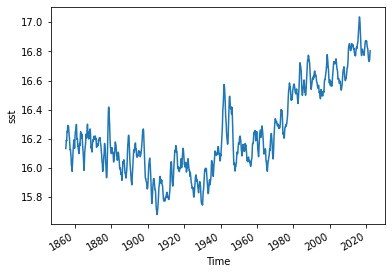

In [ ]:
# Plot the ERSST time series averaged
ersst.sst.mean(('lat', 'lon')).rolling(time=12).mean().plot()

In [ ]:
cruises_dset.lat.max()

<xarray.DataArray 'lat' ()>
array(9.1)